# Book Clustering Statistics

This notebook provides statistics on the results of our book clustering.

## Setup

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Load Data

Let's start by getting our clusters and their statistics:

In [2]:
clusters = pd.read_parquet('book-links/cluster-stats.parquet')
clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26896741 entries, 0 to 26896740
Data columns (total 8 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   cluster        int32 
 1   n_nodes        uint32
 2   n_isbns        uint32
 3   n_loc_recs     uint32
 4   n_ol_editions  uint32
 5   n_ol_works     uint32
 6   n_gr_books     uint32
 7   n_gr_works     uint32
dtypes: int32(1), uint32(7)
memory usage: 820.8 MB


In [3]:
clusters.set_index('cluster', inplace=True)

Describe the count columns for basic descriptive stats:

In [4]:
clusters.describe()

,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
count,2.689674e+07,2.689674e+07,2.689674e+07,2.689674e+07,2.689674e+07,2.689674e+07,2.689674e+07
mean,3.109125e+00,9.110410e-01,3.595447e-01,9.913082e-01,7.028788e-01,8.776732e-02,5.658537e-02
std,1.121058e+03,4.410314e+02,6.373903e+01,2.357308e+02,1.008356e+02,1.982932e+02,8.143810e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,4.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,5.813991e+06,2.287239e+06,3.305530e+05,1.222517e+06,5.229410e+05,1.028388e+06,4.223530e+05


75% of clusters only contain 2 ISBNs (probably -10 and -13) and one book. OpenLibrary also contributes to the largest number of clusters.

## Clusters per Source

How many clusters are connected to each source?

In [20]:
src_counts = pd.Series(dict(
    (c, np.sum(clusters[c] > 0)) for c in clusters.columns
))
src_counts

n_nodes          26897112
n_isbns          12446951
n_loc_recs        9031230
n_ol_editions    20105722
n_ol_works       17314446
n_gr_books         948926
n_gr_works         948410
dtype: int64

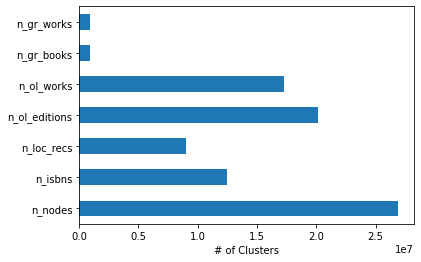

In [24]:
src_counts.plot.barh()
plt.xlabel('# of Clusters')
plt.show()

## Distributions

Let's look at the distributions of cluster sizes.

In [5]:
size_dist = pd.concat(dict(
    (c, clusters[c].value_counts()) for c in clusters.columns if c != 'n_nodes'
), names=['RecType'])
size_dist.index.set_names(['RecType', 'RecCount'], inplace=True)
size_dist = size_dist.reset_index(name='Clusters')
size_dist.head()

,RecType,RecCount,Clusters
0,n_isbns,0,14450161
1,n_isbns,2,5931482
2,n_isbns,1,5531907
3,n_isbns,4,480469
4,n_isbns,3,257451


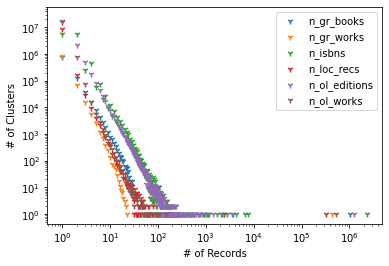

In [6]:
for rt, data in size_dist.groupby('RecType'):
    plt.scatter(data['RecCount'], data['Clusters'], marker='1', label=rt)
plt.legend()
plt.xlabel('# of Records')
plt.xscale('log')
plt.ylabel('# of Clusters')
plt.yscale('log')
plt.show()

Looks mostly fine - we expect a lot of power laws - but the number of clusters with merged GoodReads works is concerning.

## GoodReads Work Merging

Why are GoodReads works merging? Let's look at those.

In [7]:
gr_big = clusters[clusters['n_gr_works'] > 1].sort_values('n_gr_works', ascending=False)
gr_big.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98595 entries, 100000250 to 113180370
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   n_nodes        98595 non-null  uint32
 1   n_isbns        98595 non-null  uint32
 2   n_loc_recs     98595 non-null  uint32
 3   n_ol_editions  98595 non-null  uint32
 4   n_ol_works     98595 non-null  uint32
 5   n_gr_books     98595 non-null  uint32
 6   n_gr_works     98595 non-null  uint32
dtypes: uint32(7)
memory usage: 3.4 MB


We have 6K of these clusters. What fraction of the GoodReads-affected clusters is this?

In [8]:
len(gr_big) / clusters['n_gr_books'].count()

0.0036656857423730256

Less than 1%. Not bad, but let's look.

In [9]:
gr_big.head()

,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
cluster,,,,,,,
100000250,5813991,2287239,330553,1222517,522941,1028388,422353
100268975,407,166,26,64,34,79,38
100739898,375,153,19,64,34,69,36
100550086,411,159,26,101,33,61,31
100020011,251,93,20,42,24,50,22


## Output Cluster Statistics

Let's compute some cluster statistics and show them.

In [10]:
import json
with open('book-links/cluster-stats.json', 'w') as sf:
    json.dump({
        'clusters': len(clusters)
    }, sf)

## Debugging GoodReads Clusters

Let's find the clusters w/ GR but no ISBNs.

In [11]:
no_isbn = clusters['n_isbns'] < 1
have_gr = clusters['n_gr_books'] > 0
bad = clusters[no_isbn & have_gr]
bad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139940 entries, 423896385 to 450686480
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   n_nodes        139940 non-null  uint32
 1   n_isbns        139940 non-null  uint32
 2   n_loc_recs     139940 non-null  uint32
 3   n_ol_editions  139940 non-null  uint32
 4   n_ol_works     139940 non-null  uint32
 5   n_gr_books     139940 non-null  uint32
 6   n_gr_works     139940 non-null  uint32
dtypes: uint32(7)
memory usage: 4.8 MB


These are complete what-the-hell. Everything is supposed to have ISBNs.

In [12]:
gr_links = pd.read_parquet('goodreads/gr-book-link.parquet')
gr_links.set_index('book_id', inplace=True)
gr_links.head()

,work_id,cluster
book_id,,
18666965,26491738.0,426491738
10712990,15623495.0,415623495
18250353,25706055.0,425706055
15732733,21413578.0,421413578
18041331,25316309.0,425316309


In [13]:
gr_works = pd.read_parquet('goodreads/gr-work-info.parquet', columns=['work_id', 'title', 'pub_year'])
gr_works.set_index('work_id', inplace=True)
gr_works.head()

,title,pub_year
work_id,,
5400751,W. C. Fields: A Life on Film,1984.0
1323437,Good Harbor,2001.0
8948723,None,1987.0
6243154,Best Friends Forever,2009.0
278577,Runic Astrology: Starcraft and Timekeeping in ...,1990.0


In [14]:
gr_info = pd.read_parquet('goodreads/gr-book-ids.parquet')
gr_info.set_index('book_id', inplace=True)
gr_info.head()

,work_id,isbn10,isbn13,asin
book_id,,,,
5333265,5400751.0,0312853122,9780312853129,None
1333909,1323437.0,0743509986,9780743509985,None
7327624,8948723.0,None,None,B00071IKUY
6066819,6243154.0,0743294297,9780743294294,None
287140,278577.0,0850308712,9780850308716,None


In [15]:
bad_link = gr_links.join(bad, on='cluster', how='right')
bad_link.head()

,work_id,cluster,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
book_id,,,,,,,,,
17280727,23896385.0,423896385,2,0,0,0,0,1,1
33640526,54491654.0,454491654,2,0,0,0,0,1,1
17822381,24930878.0,424930878,2,0,0,0,0,1,1
28928706,49145631.0,449145631,2,0,0,0,0,1,1
20997073,40372971.0,440372971,2,0,0,0,0,1,1


In [16]:
bad_li = bad_link.join(gr_info.drop(columns=['work_id']))
bad_li

,work_id,cluster,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works,isbn10,isbn13,asin
book_id,,,,,,,,,,,,
17280727,23896385.0,423896385,2,0,0,0,0,1,1,None,None,None
33640526,54491654.0,454491654,2,0,0,0,0,1,1,None,None,None
17822381,24930878.0,424930878,2,0,0,0,0,1,1,None,None,None
28928706,49145631.0,449145631,2,0,0,0,0,1,1,None,None,None
20997073,40372971.0,440372971,2,0,0,0,0,1,1,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
31853087,51592180.0,451592180,11,0,0,0,0,10,1,None,None,None
22642978,42144315.0,442144315,2,0,0,0,0,1,1,None,None,None
29339205,49573723.0,449573723,2,0,0,0,0,1,1,None,None,None


This shows that these are books with no ISBN data.

### GR-only clusters

Now let's look for clusters that only have GoodReads records.

In [17]:
gr_only = clusters['n_loc_recs'] < 1
gr_only &= clusters['n_ol_editions'] < 1
gr_only &= clusters['n_ol_works'] < 1
gr_cs = clusters[gr_only].sort_values('n_nodes', ascending=False)
gr_cs

,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
cluster,,,,,,,
440929705,61,26,0,0,0,34,1
419930525,39,16,0,0,0,22,1
426685238,28,13,0,0,0,14,1
415234137,25,13,0,0,0,11,1
426174277,24,13,0,0,0,10,1
...,...,...,...,...,...,...,...
923678286,1,1,0,0,0,0,0
923678284,1,1,0,0,0,0,0
923678283,1,1,0,0,0,0,0


Let's look at IDs in one of these early clusters.

In [18]:
big = gr_links[gr_links['cluster'] == gr_cs.index[2]]
big[['cluster']].join(gr_info).join(gr_works, on='work_id')

,cluster,work_id,isbn10,isbn13,asin,title,pub_year
book_id,,,,,,,
20746146,426685238,26685238.0,None,None,B00I4QUVRE,Am I small? jega jagnayo?,2013.0
32609336,426685238,26685238.0,None,None,None,Am I small? jega jagnayo?,2013.0
21903425,426685238,26685238.0,None,None,B00I8PDZW4,Am I small? jega jagnayo?,2013.0
20764762,426685238,26685238.0,None,None,B00I44X0U6,Am I small? jega jagnayo?,2013.0
21461634,426685238,26685238.0,None,None,B00F209TRI,Am I small? jega jagnayo?,2013.0
23992371,426685238,26685238.0,None,None,B00LAHC3AC,Am I small? jega jagnayo?,2013.0
25015470,426685238,26685238.0,None,None,B00M0SRUIK,Am I small? jega jagnayo?,2013.0
20808249,426685238,26685238.0,None,None,B00I9NS72S,Am I small? jega jagnayo?,2013.0
22098070,426685238,26685238.0,None,None,B00IBFL25I,Am I small? jega jagnayo?,2013.0
